In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import matplotlib.gridspec as gridspec
import glob
import netCDF4 as ncdf
from pynhhd import nHHD

import time

from datetime import datetime

# Local import 

from spectra.py_spectra import *


In [25]:
#-----------------------------------------------------------------
#
# This code can run and plot power spectra from a single day
#

def compute_nhhd(in_dir, out_dir, day, suffix_name = ["HRRR_ECONUS", "RRFS_ECONUS"], analysis_levels = [4, 34]):
    
    def write_npz(filename_src, ur,vr,wr, ud,vd,wd, uh,vh,wh, z, lats, lons):
        
        dct = {'ur': ur, 'vr': vr, 'wr':wr, 
               'ud': ur, 'vd': vr, 'wd':wr,
               'uh': ur, 'vh': vr, 'wh':wr,
               'z':   z, 'lats': lats, 'lons': lons}
        
        filename = filename_src[:-3]+"_nhhd"
        
        np.savez(filename, **dct)
        
        print("Wrote out: ", filename+".npz")
        
    def write_xr(filename_src, ur,vr,wr, ud,vd,wd, uh,vh,wh, fhour, z, lats, lons):

        ds = xr.Dataset({
                        'ur': xr.DataArray(
            data   = ur, dims = ['fhour', 'nz','ny','nx'], 
            coords={"lats": (["ny","nx"], lats), "lons": (["ny","nx"], lons),"z": (["nz"], z), "fhour": (["fhour"], fhour)} ),
                         'vr': xr.DataArray(
            data   = vr, dims = ['fhour', 'nz','ny','nx'],
            coords={"lats": (["ny","nx"], lats), "lons": (["ny","nx"], lons),"z": (["nz"], z), "fhour": (["fhour"], fhour) } ),
                         'wr': xr.DataArray(
            data   = wr, dims = ['fhour', 'nz','ny','nx'], 
            coords={"lats": (["ny","nx"], lats), "lons": (["ny","nx"], lons),"z": (["nz"], z), "fhour": (["fhour"], fhour) } ), 
                         'ud': xr.DataArray(
            data   = ud, dims = ['fhour', 'nz','ny','nx'],
            coords={"lats": (["ny","nx"], lats), "lons": (["ny","nx"], lons),"z": (["nz"], z), "fhour": (["fhour"], fhour) } ),
                         'vd': xr.DataArray(
            data   = vd, dims = ['fhour', 'nz','ny','nx'],
            coords={"lats": (["ny","nx"], lats), "lons": (["ny","nx"], lons),"z": (["nz"], z), "fhour": (["fhour"], fhour) } ),
                         'wd': xr.DataArray(
            data   = wd, dims = ['fhour', 'nz','ny','nx'], 
            coords={"lats": (["ny","nx"], lats), "lons": (["ny","nx"], lons),"z": (["nz"], z), "fhour": (["fhour"], fhour) } ),  
                          'uh': xr.DataArray(
            data   = uh, dims = ['fhour', 'nz','ny','nx'],
            coords={"lats": (["ny","nx"], lats), "lons": (["ny","nx"], lons),"z": (["nz"], z), "fhour": (["fhour"], fhour) } ),
                         'vh': xr.DataArray(
            data   = vh, dims = ['fhour', 'nz','ny','nx'],
            coords={"lats": (["ny","nx"], lats), "lons": (["ny","nx"], lons),"z": (["nz"], z), "fhour": (["fhour"], fhour) } ),
                         'wh': xr.DataArray(
            data   = wh, dims = ['fhour', 'nz','ny','nx'],
            coords={"lats": (["ny","nx"], lats), "lons": (["ny","nx"], lons),"z": (["nz"], z), "fhour": (["fhour"], fhour) } ) })

        filename = filename_src[:-3]+"_nhhd3D.nc"
        
        ds.to_netcdf(filename,format='NETCDF4')
        
        print("Wrote out: ", filename)

    #-----------------------------------------------------------------------------
        
    hrrr_file = str(os.path.join(in_dir, "%s_%s.nc" % (day, suffix_name[0])))
    rrfs_file = str(os.path.join(in_dir, "%s_%s.nc" % (day, suffix_name[1])))
    
    filenames = (hrrr_file, rrfs_file)
    
    klevels = np.arange(11)
    
    # Open data sets

    hrrr = xr.open_dataset(hrrr_file) 
    rrfs = xr.open_dataset(rrfs_file)
    
    ds_objs = (hrrr, rrfs)
    
    for ds, file in zip(ds_objs, filenames):
        
        tic = time.perf_counter()
        
        print(file)
    
        # create NHHD
        
        for t in np.arange(2):

            u = np.nan_to_num(ds.u_interp.isel(fhour=t,nz=klevels).values).astype('float64')
            v = np.nan_to_num(ds.v_interp.isel(fhour=t,nz=klevels).values).astype('float64')
            w = np.nan_to_num(ds.w_interp.isel(fhour=t,nz=klevels).values).astype('float64')

            nz, ny, nx = u.shape[0:3]
            
            nhours = ds.dims['fhour']
            nhours = 2

            dims = (nz, ny, nx)  # Z Y, X
            dx   = (0.25, 3, 3)  # dz, dy, dx

            vfield = np.stack((u, v, w), axis=3)

            nhhd = nHHD(grid=dims, spacings=dx)

            nhhd.decompose(vfield)
            
            if t == 0:
                
                ur = np.zeros((nhours, nz, ny, nx))
                vr = np.zeros((nhours, nz, ny, nx))
                wr = np.zeros((nhours, nz, ny, nx))
                ud = np.zeros((nhours, nz, ny, nx))
                vd = np.zeros((nhours, nz, ny, nx))
                wd = np.zeros((nhours, nz, ny, nx))
                uh = np.zeros((nhours, nz, ny, nx))
                vh = np.zeros((nhours, nz, ny, nx))
                wh = np.zeros((nhours, nz, ny, nx))

            ur[t], vr[t], wr[t] = np.squeeze(np.split(nhhd.r, 3, axis=3))

            ud[t], vd[t], wd[t] = np.squeeze(np.split(nhhd.d, 3, axis=3))

            uh[t], vh[t], wh[t] = np.squeeze(np.split(nhhd.h, 3, axis=3))

        write_xr(file, ur,vr,wr, ud,vd,wd, uh,vh,wh, np.arange(nhours), hrrr.z[0:11].values, hrrr.lats.values, hrrr.lons.values)  
        
        toc = time.perf_counter()
        
        print(f"NHHD took {toc - tic:0.4f} seconds")

In [ ]:
in_dir  = "/work/wicker/ECONUS"
out_dir = "/work/wicker/CAM_analysis_tools/2022_spectra"
case_days = ["2022050400", 
             "2022051200",
             "2022051400",
             "2022051500",
             "2022051900",
             "2022052300",
             "2022052400",
             "2022052700",
             "2022053000",
             "2022060700"]

#case_days = ["2022060700"]

for d in case_days:
    print("Running day:  %s\n" % d)
    ret = compute_nhhd(in_dir, out_dir, d)
    

Running day:  2022050400

/work/wicker/ECONUS/2022050400_HRRR_ECONUS.nc
Wrote out:  /work/wicker/ECONUS/2022050400_HRRR_ECONUS_nhhd3D.nc
NHHD took 103.8818 seconds
/work/wicker/ECONUS/2022050400_RRFS_ECONUS.nc


In [ ]:
ds = xr.open_dataset("/work/wicker/ECONUS/2022051200_HRRR_ECONUS_nhhd_nhhd.nc")


ur = ds.ur.values
vr = ds.vr.values
wr = ds.wr.values
ds.sizes

In [12]:
divx = (ur[:,:,2:] - ur[:,:,:-2]) / 6.0
divy = (vr[:,2:,:] - vr[:,:-2,:]) / 6.0
divz = (wr[2:,:,:] - wr[:-2,:,:]) / 0.5

print(divx.shape, divy.shape, divz.shape)

dtotal = divx[1:-1,1:-1,:] + divy[1:-1,:,1:-1] + divz[:,1:-1,1:-1]

print(dtotal.shape)

print(dtotal.max(), dtotal.min())


(33, 959, 1153) (33, 957, 1155) (31, 959, 1155)
(31, 957, 1153)
1.9539925233402755e-14 -1.9539925233402755e-14


In [15]:
ud = ds.ud.values
vd = ds.vd.values
wd = ds.wd.values

rotx = (ud[:,2:,2:] - ud[:,:-2,:-2]) / 6.0
roty = (vd[:,2:,2:] - vd[:,:-2,:-2]) / 6.0
#divz = (wr[2:,:,:] - wr[:-2,:,:]) / 0.5

rot = roty - rotx
print(rot.max(), rot.min())

3.1539937143618317 -3.943957202400308


In [36]:
#-----------------------------------------------------------------
#
# This code can run and plot power spectra from a single day
#

def run_spectral_analysis(in_dir, out_dir, day, suffix_name = ["HRRR_ECONUS", "RRFS_ECONUS"], analysis_levels = [4, 34]):
    

    hrrr_file = str(os.path.join(in_dir, "%s_%s.nc" % (day, suffix_name[0])))
    rrfs_file = str(os.path.join(in_dir, "%s_%s.nc" % (day, suffix_name[1])))
    
    print(hrrr_file)
    print(rrfs_file)
    
    # Open data sets

    hrrr = xr.open_dataset(hrrr_file) 
    rrfs = xr.open_dataset(rrfs_file)
    
    zlevels = hrrr.z
    
    # create NHHD
    
    klevels = np.arange(11)
    
    hrrr_u = np.nan_to_num(hrrr.u_interp.isel(fhour=3,nz=klevels).values).astype('float64')
    hrrr_v = np.nan_to_num(hrrr.v_interp.isel(fhour=3,nz=klevels).values).astype('float64')
    hrrr_w = np.nan_to_num(hrrr.w_interp.isel(fhour=3,nz=klevels).values).astype('float64')
    
    print(hrrr_u.shape)

    nz, ny, nx = hrrr_u.shape[0:3]

    dims = (nz, ny, nx)  # Z Y, X
    dx   = (0.25, 3, 3)  # dz, dy, dx
        
    vfield = np.stack((hrrr_u, hrrr_v, hrrr_w), axis=3)

    nhhd = nHHD(grid=dims, spacings=dx)
    nhhd.decompose(vfield)
    print(nhhd.r.shape)

    hrrr_ur, hhhr_vr, hhhr_wr = np.squeeze(np.split(nhhd.r, 3, axis=3))

    hrrr_ud, hrrr_vd, hrrr_wd = np.squeeze(np.split(nhhd.d, 3, axis=3))

    hrrr_uh, hrrr_vh, hrrr_wh = np.squeeze(np.split(nhhd.h, 3, axis=3))

    print("Created HRRR NHHD")
    
    rrfs_u = np.nan_to_num(rrfs.u_interp.isel(fhour=3,nz=klevels).values).astype('float64')
    rrfs_v = np.nan_to_num(rrfs.v_interp.isel(fhour=3,nz=klevels).values).astype('float64')
    rrfs_w = np.nan_to_num(rrfs.w_interp.isel(fhour=3,nz=klevels).values).astype('float64')
    
    print(rrfs_u.shape)

    nz, ny, nx = rrfs_u.shape[0:3]

    dims = (nz, ny, nx)  # Y, X
    dx = (0.25, 3, 3)             # dy, dx

    vfield = np.stack((rrfs_u, rrfs_v, rrfs_w), axis=3)
    
    nhhd = nHHD(grid=dims, spacings=dx)
    nhhd.decompose(vfield)
    
    print(nhhd.r.shape)

    rrfs_ur, rrfs_vr, rrfs_wr = np.squeeze(np.split(nhhd.r, 3, axis=3))

    rrfs_ud, rrfs_vd, rrfs_wd = np.squeeze(np.split(nhhd.d, 3, axis=3))
    
    rrfs_uh, rrfs_vh, rrfs_wh = np.squeeze(np.split(nhhd.h, 3, axis=3))
    
    print(rrfs_ur.shape)

    print("Created RRFS NHHD")
    
    # Loop over the analy_klevels to create multiple plots

    for k in analysis_levels:

        # these three levels are averaged together

        klevels = [k]
        
        # Compute spectra...

        fig = plt.figure(constrained_layout=True,figsize=(20,10))

        ylim = [1.0e4,1.0e15]
        axis    = 0
        func    = get_spectra2D_RAD
        detrend = True

        gs = gridspec.GridSpec(1, 2, figure=fig)

        ax1 = fig.add_subplot(gs[0, 0])

        # plot_spectra(rrfs_w, func=get_spectra2D_DCT, axis=axis, ax=[ax1], detrend=detrend, legend='', PScolor='g', ylim=ylim)       
        # plot_spectra(hrrr_w, func=get_spectra2D_DCT, axis=axis, ax=[ax1], detrend=detrend, legend='', PScolor='b', ptitle = 'W', ylim=ylim)

        plot_spectra(rrfs_ur, varray=rrfs_vr, func=func, axis=axis, ax=[ax1], detrend=detrend, legend='', PScolor='r', ylim=ylim)      
        plot_spectra(rrfs_uh, varray=rrfs_vh, func=func, axis=axis, ax=[ax1], detrend=detrend, legend='', PScolor='g', ylim=ylim) 
        plot_spectra(hrrr_uh, varray=hrrr_vh, func=func, axis=axis, ax=[ax1], detrend=detrend, legend='', PScolor='g', ylim=ylim)  
        plot_spectra(hrrr_ur, varray=rrfs_vr, func=func, axis=axis, ax=[ax1], detrend=detrend, legend='HRRR:black\nRRFS:red',ptitle='VKE',PScolor='k',LinsborgSlope=True,ylim=ylim)
            
        ax1 = fig.add_subplot(gs[0, 1])
        
        # plot_spectra(rrfs_u, varray=rrfs_v, func=get_spectra2D_DCT, axis=axis, ax=[ax1], detrend=detrend, legend='', PScolor='g', ylim=ylim, PSline='-.')    
        # plot_spectra(hrrr_u, varray=hrrr_v, func=get_spectra2D_DCT, axis=axis, ax=[ax1], detrend=detrend, legend='', PScolor='b', ptitle = 'Hor. KE', ylim=ylim, PSline='-.')

        plot_spectra(rrfs_ud, varray=rrfs_vd, func=func, axis=axis, ax=[ax1], detrend=detrend, legend='', PScolor='r', ylim=ylim)
        plot_spectra(hrrr_ud, varray=hrrr_vd, func=func, axis=axis, ax=[ax1], detrend=detrend, legend='HRRR:black\nRRFS:red', ptitle = 'DKE', PScolor='k', LinsborgSlope=True, ylim=ylim)

        plt.suptitle("W-Spectra Avg Case Day %s \n Height Level: %3.1f km" % (day, zlevels[k]/1000.), fontsize=20)

        plt.savefig("%s/%s_%s_%3.1fkm.png" % (out_dir, day, 'W_KE_Spectra', zlevels[k]/1000.),bbox_inches='tight', dpi=300)


Running day:  2022051400

/work/wicker/ECONUS/2022051400_HRRR_ECONUS.nc
/work/wicker/ECONUS/2022051400_RRFS_ECONUS.nc
(11, 959, 1155)
(11, 959, 1155, 3)
Created HRRR NHHD
(11, 959, 1155)
(11, 959, 1155, 3)
(11, 959, 1155)
Created RRFS NHHD
----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum computed for KE
plot_spectra: DETREND = True

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called


----------------------------------------------------------------------------------------------------
plot_spectra: Computing power spectrum using function: get_spectra2D_RAD
plot_spectra: Spectrum computed for KE
plot_spectra: DETREND = True

                    -------------------------------------------------------------------------

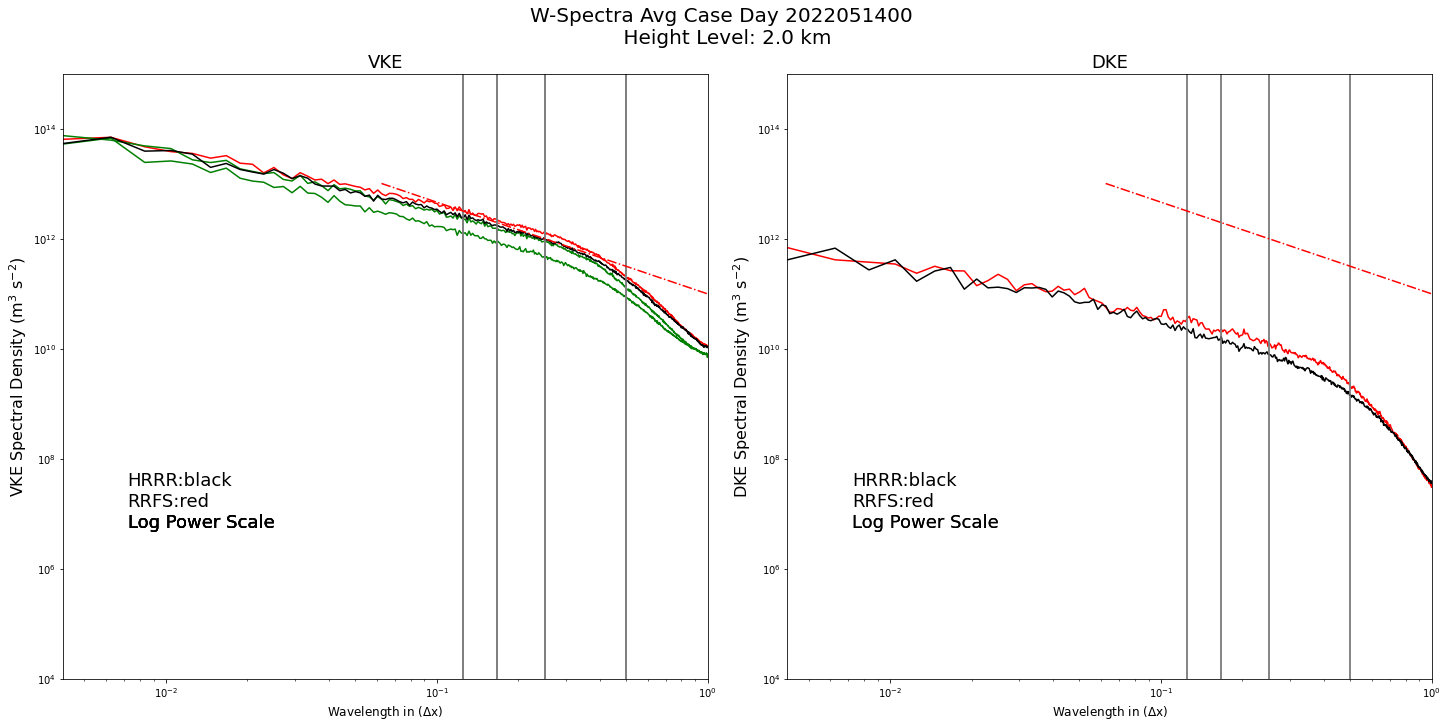

In [37]:
in_dir  = "/work/wicker/ECONUS"
out_dir = "/work/wicker/CAM_analysis_tools/2022_spectra"
case_days = ["2022051400"]

            # ["2022050400"]
            # # ,"2022051200",
            # # "2022051400",
            # # "2022051500",
            # # "2022051900",
            # # "2022052300",
            # # "2022052400",
            # # "2022052700",
            # # "2022053000",
            # # "2022060700"]

#case_days = ["2022060700"]

for d in case_days:
    print("Running day:  %s\n" % d)
    ret = run_spectral_analysis(in_dir, out_dir, d, analysis_levels = [4])
    


====> Begin processing runs


----> Processing run: HRRR for day:  2022050400 

          /work/wicker/ECONUS/2022050400_HRRR_ECONUS.nc

          ----------------------------------------------------------------------------------------------------
          get_spectraND: Reshaped array so that spectra averaged over outer dimension: 18

                    ----------------------------------------------------------------------------------------------------
                    get_spectra2D_RAD is now being called
                                        Input array variance         DFT Variance
                                        -----------------------------------------
                                          0.07250541422              0.07247282481

                                        Input array variance         DFT Variance
                                        -----------------------------------------
                                           0.1107912447              

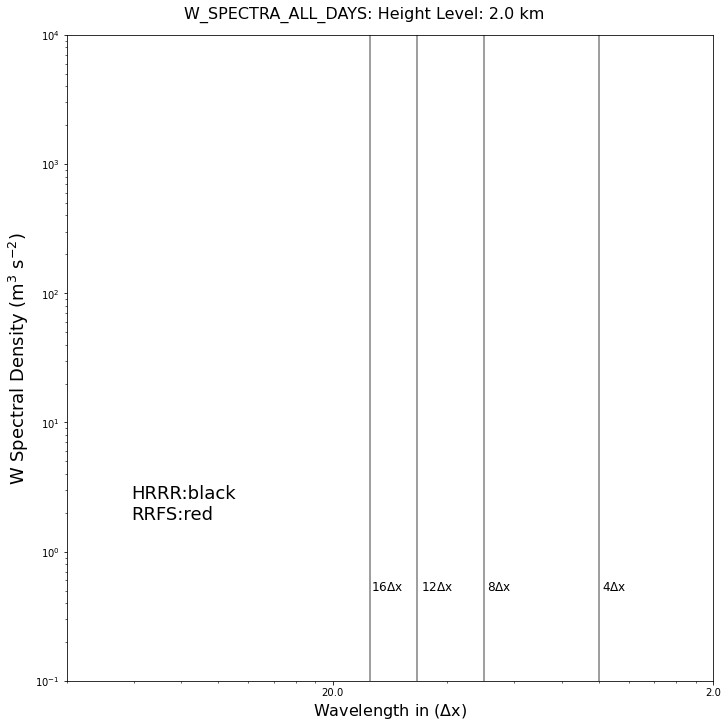

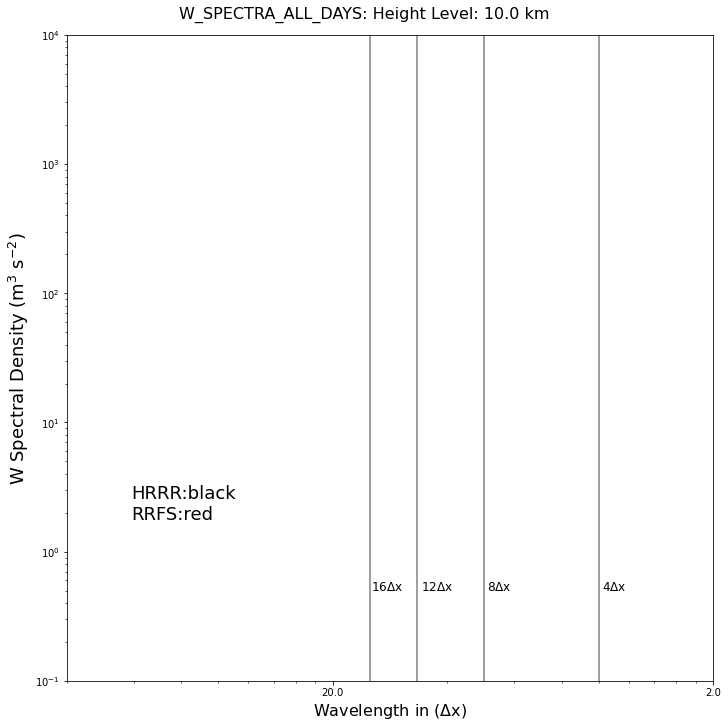

In [5]:
import matplotlib.ticker as mticker

analysis_levels  = [4, 34]

def update_ticks(x, pos):
    if x != 0.0:
        return "%2.1f" % (2.0/x)
    else:
        return r'$\infty$'

in_dir  = "/work/wicker/ECONUS"
out_dir = "/work/wicker/CAM_analysis_tools/2022_spectra"
case_days = ["2022050400",
            "2022051200",
            "2022051400",
            "2022051500",
            "2022051900",
            "2022052300",
            "2022052400",
            "2022052700",
            "2022053000",
            "2022060700"]

ncases = len(case_days)

avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)

ret_data =  {"HRRR":[], 
             "RRFS":[]}

avg_data = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
            "RRFS":np.zeros((ncases,avg_grid.shape[0],))}

func   = get_spectra2D_RAD
dtrend = True
axis   = None

delta  = False

suffix_names = ["HRRR","RRFS"]
region = "ECONUS"
#------------------------------------------------------------------------------------
#

print("\n====> Begin processing runs\n")

for k in analysis_levels:
    for n, day in enumerate(case_days):
        for run in suffix_names:

            print("\n----> Processing run: %s for day:  %s \n" % (run, day))
            
            myfile  = str(os.path.join(in_dir, "%s_%s_%s.nc" % (day, run, region)))
            print("          %s\n" % myfile)

            # Open data set

            data = xr.open_dataset(myfile)
            
            zlevels = data.z
            
            # Loop over the analy_klevels to create multiple plots

            # these five levels are averaged together

            klevels = [k-1, k, k+1]

            # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

            data_w = np.nan_to_num(data.w_interp.isel(nz=klevels).values).astype('float64')

            # Compute spectra...

            ret = get_spectraND(data_w, func = func, dtrend = dtrend)

            ret_data[run].append(ret)

            avg_data[run][n][:] = np.interp(avg_grid, ret[2], ret[1])
            
            data.close()


# Now post the runs....

    legend='HRRR:black\nRRFS:red'

    avg_hrrr = avg_data['HRRR'].mean(axis=0)
    avg_rrfs = avg_data['RRFS'].mean(axis=0)

    fig, axes = plt.subplots(1, 1, constrained_layout=True,figsize=(10,10))

    if delta:
        delta_rrfs = avg_rrfs[12]-avg_hrrr[12]
        axes.loglog(avg_grid, avg_hrrr+delta_rrfs,  color='black')
    else:
        axes.loglog(avg_grid, avg_hrrr,  color='black')
        
    axes.loglog(avg_grid, avg_rrfs, color='red')
    
    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.annotate("%s" % legend, xy=(0.10, 0.25), xycoords='axes fraction', color='k',fontsize=18)
    axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    ylim    = [0.1,1.0e4]
        
    axes.set_ylim(ylim[0], ylim[1])

    ylabel = 5. * ylim[0]

    xoffset = [0.01, 0.005, 0.0035, 0.001]

    for n, w in enumerate([4.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"W Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)

    # plt.title(ptitle, fontsize=18)

    plt.suptitle("W_SPECTRA_ALL_DAYS: Height Level: %3.1f km" % (zlevels[k]/1000.), fontsize=16)

    plt.savefig("%s/%s_%3.1fkm.png" % (out_dir, 'W_SPECTRA_ALL', zlevels[k]/1000.),bbox_inches='tight',dpi=300)



In [ ]:
import matplotlib.ticker as mticker

analysis_levels  = [4, 34]

def update_ticks(x, pos):
    if x != 0.0:
        return "%2.1f" % (2.0/x)
    else:
        return r'$\infty$'

in_dir  = "/work/wicker/ECONUS"
out_dir = "/work/wicker/CAM_analysis_tools/2022_spectra"
case_days = ["2022050400",
            "2022051200",
            "2022051400",
            "2022051500",
            "2022051900",
            "2022052300",
            "2022052400",
            "2022052700",
            "2022053000",
            "2022060700"]

ncases = len(case_days)

avg_grid = 0.005 + 0.985* np.linspace(0.0, 1.0, num=100, endpoint=True)

ret_data =  {"HRRR":[], 
             "RRFS":[]}

avg_data = {"HRRR":np.zeros((ncases,avg_grid.shape[0],)), 
            "RRFS":np.zeros((ncases,avg_grid.shape[0],))}

func = get_spectra2D_RAD
dtrend = False
axis = None

delta = False

suffix_names = ["HRRR","RRFS"]
region = "ECONUS"
#------------------------------------------------------------------------------------
#

print("\n====> Begin processing runs\n")

for k in analysis_levels:
    for n, day in enumerate(case_days):
        for run in suffix_names:

            print("\n----> Processing run: %s for day:  %s \n" % (run, day))
            
            myfile  = str(os.path.join(in_dir, "%s_%s_%s.nc" % (day, run, region)))
            print("          %s\n" % myfile)

            # Open data set

            data = xr.open_dataset(myfile)
            
            zlevels = data.z
            
            # Loop over the analy_klevels to create multiple plots

            # these five levels are averaged together

            klevels = [k-1, k, k+1]

            # Convert to numpy arrays, fill in zeros, compute horizontal TKE.

            data_u = np.nan_to_num(data.u_interp.isel(nz=klevels).values).astype('float64')
            data_v = np.nan_to_num(data.v_interp.isel(nz=klevels).values).astype('float64')

            # Compute spectra...

            ret = get_spectraND(data_u, varray=data_v, func = func, detrend=dtrend)

            ret_data[run].append(ret)

            avg_data[run][n][:] = np.interp(avg_grid, ret[2], ret[1])
            
            data.close()

# Now post the runs....

    legend='HRRR:black\nRRFS:red'

    avg_hrrr = avg_data['HRRR'].mean(axis=0)
    avg_rrfs = avg_data['RRFS'].mean(axis=0)

    fig, axes = plt.subplots(1, 1, constrained_layout=True,figsize=(10,10))

    if delta:
        delta_rrfs = avg_rrfs[12]-avg_hrrr[12]
        axes.loglog(avg_grid, avg_hrrr+delta_rrfs,  color='black')
    else:
        axes.loglog(avg_grid, avg_hrrr,  color='black')
        
    axes.loglog(avg_grid, avg_rrfs, color='red')
    
    axes.set_xlim(2.0/avg_grid.shape[0], 1.0)

    axes.annotate("%s" % legend, xy=(0.10, 0.25), xycoords='axes fraction', color='k',fontsize=18)
    axes.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

    ylim = [1.0e1,1.0e6]

    axes.set_ylim(ylim[0], ylim[1])

    ylabel = 5. * ylim[0]

    xoffset = [0.0075, 0.0035, 0.0025, 0.001]

    for n, w in enumerate([4.0, 8.0, 12.0, 16.0]):
        axes.axvline(x = (2.0/w), color = 'grey', label = 'axvline - full height')  
        axes.annotate(r"%d$\Delta$x" % w, xy=(2.0/w + xoffset[n], ylabel), xycoords='data', color='k',fontsize=12)
        
    xpt = [2.0/16.,2.0/2.0]
    dlnx = np.log(xpt[1]) - np.log(xpt[0])
    y1   = ylim[1]/(100.)
    y0   = np.exp(np.log(y1) + 5./3. * dlnx)
    ypt  = [y0,y1]
    axes.loglog(xpt, ypt, color='red',linestyle='-.',label='k$^{-5/3}$')

    axes.set_xlabel(r"Wavelength in ($\Delta$x)", fontsize=16)
    axes.set_ylabel(r"KE Spectral Density (m$^3$ s$^{-2}$)", fontsize=18)

    plt.suptitle("KE_SPECTRA_ALL_DAYS: Height Level: %3.1f km" % (zlevels[k]/1000.), fontsize=16)

    plt.savefig("%s/%s_%3.1fkm.png" % (out_dir, 'KE_SPECTRA_ALL', zlevels[k]/1000.),bbox_inches='tight',dpi=300)
    
    